# Allora Forge ML Workflow

This notebook with help you get started submitting inferences to the Allora network and take part in the Forge competition.

## In this notebook you will quickly be able to:

  1. Load training and validation data.
  2. Load a LightGBM model
  3. Train the model
  4. Evaluate the model on validation data (recent 6 months)
  5. Package your predict function into a `.pkl` file
  6. (TODO: Run your worker to deliver inference to the network)

## What you will need

  1. Allora Data API Key
  2. (Allora Network Wallet Address for live predictions) - under construction
  3. (Forge Competition Topic ID for live predictions) - under construction

# Happy Coding

Let's go.

## Install all necessary packages

In [2]:
'''
Install all necessary packages
'''

%pip install git+https://github.com/allora-network/allora-forge-ml-workflow.git
%pip install lightgbm scikit-learn pandas numpy matplotlib dill 
%pip install torch torchvision torchaudio
%pip install xgboost
%pip install catboost

  Cloning https://github.com/allora-network/allora-forge-ml-workflow.git to /private/var/folders/g6/j6nwrg491cs5z3lb6pvlm3gw0000gn/T/pip-req-build-huup1xab
  Running command git clone --filter=blob:none --quiet https://github.com/allora-network/allora-forge-ml-workflow.git /private/var/folders/g6/j6nwrg491cs5z3lb6pvlm3gw0000gn/T/pip-req-build-huup1xab
  Resolved https://github.com/allora-network/allora-forge-ml-workflow.git to commit 845a09e8706ae3176d0c81bff3889f7680ff476b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

The following libraries are required for this workflow:
- `allora_ml_workflow` for interfacing with the Allora Forge ML Workflow.
- `lightgbm` for model training.
- `pandas` and `numpy` for data manipulation.
- `dill` for serialization.
- `matplotlib` for visualization.
- `time` for timing operations.

These will be imported in the next code cell.

In [3]:
# Import directly from local file instead of package
import sys
import os

# Remove any existing allora_ml_workflow from sys.modules
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('allora_ml_workflow')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Add local directory to path at the beginning
local_path = '/Users/elliottsaslow/projects/allora-notebook/allora-forge-ml-workflow'
if local_path in sys.path:
    sys.path.remove(local_path)
sys.path.insert(0, local_path)

# Import from local version
from allora_ml_workflow.workflow import AlloraMLWorkflow

# Verify we're using the local version
import inspect
print(f"AlloraMLWorkflow module location: {inspect.getfile(AlloraMLWorkflow)}")

# Check if our methods exist
workflow_methods = [method for method in dir(AlloraMLWorkflow) if not method.startswith('_')]
print(f"Available methods: {len(workflow_methods)}")
print(f"Methods: {workflow_methods}")

if 'compute_technical_indicators' in workflow_methods:
    print("✅ Technical indicators method found!")
else:
    print("❌ Technical indicators method NOT found!")

if 'compute_esoteric_features' in workflow_methods:
    print("✅ Esoteric features method found!")
else:
    print("❌ Esoteric features method NOT found!")

import lightgbm as lgb
import pandas as pd
import dill
import time
import matplotlib.pyplot as plt
import numpy as np

AlloraMLWorkflow module location: /Users/elliottsaslow/projects/allora-notebook/allora-forge-ml-workflow/allora_ml_workflow/workflow.py
Available methods: 23
Methods: ['calculate_bollinger_bands', 'calculate_fractal_dimension', 'calculate_hurst_exponent', 'calculate_macd', 'calculate_permutation_entropy', 'calculate_recurrence_features', 'calculate_rsi', 'calculate_sample_entropy', 'calculate_stochastic', 'calculate_wavelet_features', 'compute_esoteric_features', 'compute_from_date', 'compute_target', 'compute_technical_indicators', 'create_5_min_bars', 'evaluate_test_data', 'extract_rolling_daily_features', 'fetch_bucket_csv', 'fetch_ohlcv_data', 'get_full_feature_target_dataframe', 'get_live_features', 'get_train_validation_test_data', 'list_ready_buckets']
✅ Technical indicators method found!
✅ Esoteric features method found!


## API KEY
This gives you access to OHLCV (open, high, low, close, volume) candle data through the workflow.

To get your API key, go to [https://developer.allora.network/](https://developer.allora.network/),  
create an account, and generate a new API key.

In [4]:
api_key = "UP-26ca6c6f4129490ca3cdc09a" #need to get an API key from the Allora Forge

## Initializing the Workflow
### Defining Assets, Input Feature Window, Target

Before training a model, we need to specify how much historical data to use as input features, and how far into the future we want to predict (the target). In this section, we define the parameters that control the *shape* and *amount* of our input features, which are simply normalized historical OHLCV candles.

- **tickers**: The set of tickers for data.
- **hours_needed**: This sets the total length (in hours) of the lookback window, i.e., how much historical context the model will see for each prediction.
- **number_of_input_candles**: This determines how many candles (or chunks) the lookback window is divided into. Each candle summarizes a portion of the lookback window, and together they form the input features.
- **target_length**: This specifies how many hours into the future we want to predict. For the Allora Forge competition, this should match the target horizon required by the challenge.

For example:

- Setting `hours_needed = 72` and `number_of_input_candles = 3` gives **3 daily candles** as input (each candle covers 24 hours).
- Setting `hours_needed = 24` and `number_of_input_candles = 24` gives **24 hourly candles** as input (each candle covers 1 hour).

We'll visualize the resulting features a few cells below, so you can see exactly what the model will receive as input.

In [5]:
tickers = ["btcusd", "ethusd", "solusd"]
hours_needed = 1*24             # Number of historical hours for feature lookback window
number_of_input_candles = 24    # Number of candles for input features
target_length = 1*24            # Number of hours into the future for target

# Instantiate the workflow
workflow = AlloraMLWorkflow(
    data_api_key=api_key,
    tickers=tickers,
    hours_needed=hours_needed,
    number_of_input_candles=number_of_input_candles,
    target_length=target_length
)

## Getting Data
### Training, Validation, and Test Data for Supervised Learning

The `get_train_validation_test_data` function splits your historical data into three consecutive time periods: **training**, **validation**, and **test**. This is a standard approach in supervised machine learning to ensure that your model is evaluated on data it has never seen during training.

### Arguments:
- **`from_month`**: The starting month (YYYY-MM) for the entire dataset. The earliest available is `"2020-01"`.
- **`validation_months`**: Number of months to reserve for the validation set (used for tuning hyperparameters and early stopping).
- **`test_months`**: Number of months to reserve for the test set (used for final evaluation).

### Data Splits:
The data is split chronologically:
1. **Training Set**: Includes all data from `from_month` up to the start of the validation period.
2. **Validation Set**: Immediately follows the training set, with an embargo (gap) equal to the prediction target length (e.g., 24 hours) to prevent data leakage.
3. **Test Set**: Follows the validation set, again separated by an embargo of the same length.

### How Long Does it Take?
Loading data should only take a few minutes, and versions of data are cached for quicker load times in the future. 
- Force a re-download of fresh data with `force_redownload=True`.

### Visual Schematic:
For a 24-hour target:

| **Training Set** | → **24 hr** → | **Validation Set** | → **24 hr** → | **Test Set** |


In [6]:
# Get training, validation, and test data
X_train, y_train, X_val, y_val, X_test, y_test = workflow.get_train_validation_test_data(
    from_month="2023-01",
    validation_months=3,
    test_months=3,
    force_redownload=False  # Set to True to force re-download of fresh data
)

# Example: Check the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Loading data from data_btcusd_ethusd_solusd_2023-01_val3_test3.pkl
Training set: (660943, 239) (660943,)
Validation set: (76404, 239) (76404,)
Test set: (78618, 239) (78618,)


In [7]:
# Show the features (column names) in the dataframes
print("\nFeatures in X_train:")
print(X_train.columns.tolist())

# Optionally, show more detailed info about the features
print("\nDetailed feature info:")
print(X_train.info())

# Show first few rows to see actual data
print("\nFirst 5 rows of training data:")
print(X_train.head())


Features in X_train:
['open', 'high', 'low', 'close', 'volume', 'trades_done', 'returns', 'log_returns', 'sma_5', 'ema_5', 'price_to_sma_5', 'price_to_ema_5', 'sma_10', 'ema_10', 'price_to_sma_10', 'price_to_ema_10', 'sma_20', 'ema_20', 'price_to_sma_20', 'price_to_ema_20', 'sma_50', 'ema_50', 'price_to_sma_50', 'price_to_ema_50', 'price_change_1', 'momentum_1', 'price_change_3', 'momentum_3', 'price_change_5', 'momentum_5', 'price_change_10', 'momentum_10', 'rsi_14', 'rsi_7', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 'macd', 'macd_signal', 'macd_histogram', 'stoch_k', 'stoch_d', 'volatility_5', 'log_volatility_5', 'volatility_10', 'log_volatility_10', 'volatility_20', 'log_volatility_20', 'tr', 'atr_14', 'atr_7', 'hl_ratio', 'co_ratio', 'price_position', 'volume_sma_5', 'volume_ratio_5', 'volume_sma_10', 'volume_ratio_10', 'volume_sma_20', 'volume_ratio_20', 'obv', 'obv_sma_10', 'obv_ratio', 'vpt', 'vpt_sma_10', 'price_volume_corr_10', 'price_volume_corr_20', 'higher_high_5'

## Visualizing Data Time Spans

The next cell visualizes the time spans covered by the training, validation, and test datasets. This helps to ensure that the data splits are correctly separated in time and that there is no data leakage between them.

Training set: 2023-01-02 00:00:00+00:00 to 2025-02-05 02:55:00+00:00
Validation set: 2025-02-06 03:00:00+00:00 to 2025-05-06 02:55:00+00:00
Test set: 2025-05-07 03:00:00+00:00 to 2025-08-06 02:45:00+00:00


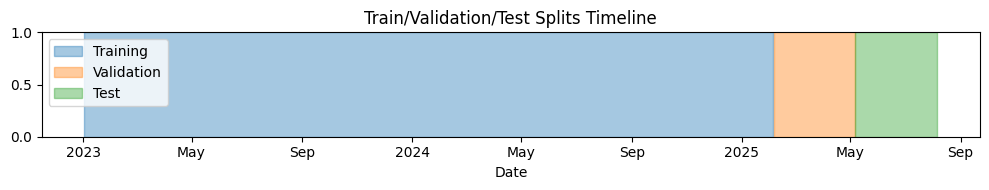

In [8]:
# Print start and end dates for each split
def print_split_dates(X, name):
    if isinstance(X.index, pd.MultiIndex):
        dates = X.index.get_level_values(0)
    else:
        dates = X.index
    print(f"{name} set: {dates.min()} to {dates.max()}")

print_split_dates(X_train, "Training")
print_split_dates(X_val, "Validation")
print_split_dates(X_test, "Test")

# Visualize the splits on a timeline
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 2))

def plot_span(X, color, label):
    if isinstance(X.index, pd.MultiIndex):
        dates = X.index.get_level_values(0)
    else:
        dates = X.index
    ax.axvspan(dates.min(), dates.max(), color=color, alpha=0.4, label=label)

plot_span(X_train, 'tab:blue', 'Training')
plot_span(X_val, 'tab:orange', 'Validation')
plot_span(X_test, 'tab:green', 'Test')

ax.legend(loc='upper left')
ax.set_title("Train/Validation/Test Splits Timeline")
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.tight_layout()
plt.show()

## Visualizing Features and Historical Price Process

In the next cell, we select a single row of data and visualize the features associated with it. These features represent the normalized historical OHLCV (open, high, low, close, volume) candles leading up to the selected time index. 

To provide additional context, we overlay the historical price process during the same time period. This allows us to visually compare the input features with the actual price movements of the asset, offering insights into the relationship between the features and the price process.


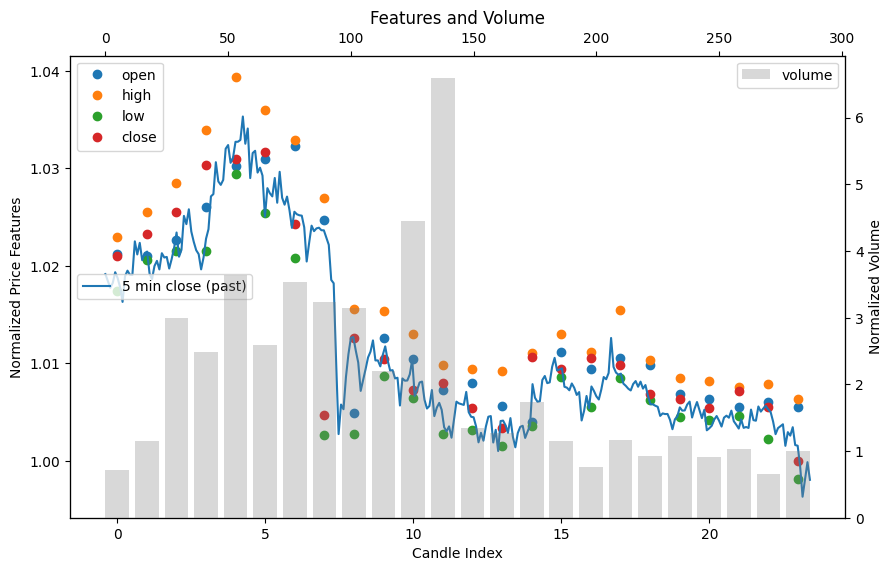

In [9]:
eth_data = X_train.loc[(slice(None), 'ethusd'), :]
data_idx = -10000  # which data point to visualize

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot features based on data_idx
ax1.plot([eth_data.iloc[data_idx][f"feature_open_{i}"] for i in range(number_of_input_candles)], 'o', label="open")
ax1.plot([eth_data.iloc[data_idx][f"feature_high_{i}"] for i in range(number_of_input_candles)], 'o', label="high")
ax1.plot([eth_data.iloc[data_idx][f"feature_low_{i}"] for i in range(number_of_input_candles)], 'o', label="low")
ax1.plot([eth_data.iloc[data_idx][f"feature_close_{i}"] for i in range(number_of_input_candles)], 'o', label="close")
ax1.set_xlabel("Candle Index")
ax1.set_ylabel("Normalized Price Features")
ax1.legend(loc="upper left")

# Plot past price process based on data_idx
plt.twiny()
plt.plot(
    (eth_data.iloc[data_idx - (hours_needed * 12):data_idx]['close'].values) / eth_data.iloc[data_idx]['close'],
    label="5 min close (past)"
)
plt.legend(loc='center left')

# Plot volume as a bar chart with independent y-axis
ax2 = ax1.twinx()
ax2.bar(range(number_of_input_candles), 
    [eth_data.iloc[data_idx][f"feature_volume_{i}"] for i in range(number_of_input_candles)], 
    alpha=0.3, color='gray', label="volume")
ax2.set_ylabel("Normalized Volume")
ax2.legend(loc="upper right")


plt.title("Features and Volume")
plt.show()

## "Hello World!" ML Model

- This notebook demonstrates a simple **LightGBM model** that predicts the future price of an asset based on its past price process, as represented by the features.
- The **validation set** is used to:
    - Tune the model.
    - Perform **early stopping**, which helps prevent overfitting.
- The **test set** is used to evaluate the model's performance.

### Workflow Summary:
1. The model is trained on the **training set**.
2. Early stopping is applied using the **validation set** to determine the best iteration.
3. The model is retrained on the combined **training and validation data** using the best iteration found during training.
4. Finally, the model is evaluated on the **test set**.

---

### Future Directions:
- This is just one example of a modeling workflow. 
- This is where a lot of **modeling magic** can happen:
    - Experiment with swapping in new techniques and models.
    - Try different feature engineering strategies.
    - Explore alternative evaluation metrics.
- Stay tuned! More notebooks will be available in the future with **different ideas and approaches** to inspire your modeling journey.

In [ ]:
import sys
sys.path.append("..")  # Only needed once

from train import run_training

# Call training function and get predictions
test_preds = run_training(X_train, y_train, X_val, y_val, X_test)


🧹 Preprocessing...
🔁 Starting training...
Epoch 001 | Loss: nan | Val Corr: nan   
Epoch 002 | Loss: nan | Val Corr: nan   
Epoch 003 | Loss: nan | Val Corr: nan   
Epoch 004 | Loss: nan | Val Corr: nan   
Epoch 005 | Loss: nan | Val Corr: nan   


## The Workflow has a built-in method to evaluate the test data predictions.

In [ ]:
#show test metrics
metrics = workflow.evaluate_test_data(test_preds)
print(metrics)

NameError: name 'test_preds' is not defined

## Retraining for live deployment
The model is finally re-trained on the entire dataset, including the test data,
before it is packaged into a pickled function for live predictions.

The `workflow.get_live_features` function creates a version of the features based on the most up-to-date live data, in exactly the same way that the historical data features were created, ensuring the model is getting coherent live data.

In [ ]:
model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]]), 
    pd.concat([y_train, y_val, y_test])
)

# Final predict function
def predict() -> pd.Series:
    live_features = workflow.get_live_features("btcusd")
    preds = model.predict(live_features)
    return pd.Series(preds, index=live_features.index)

# Pickle the function
with open("predict.pkl", "wb") as f:
    dill.dump(predict, f)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36210
[LightGBM] [Info] Number of data points in the train set: 815965, number of used features: 142
[LightGBM] [Info] Start training from score 0.002022


## Test Live Predictions

This function simulates a live prediction scenario by loading the pickled function,
calling it, and printing the prediction time and result.

In [ ]:
# Load the pickled predict function
with open("predict.pkl", "rb") as f:
    predict_fn = dill.load(f)

# Call the function and get predictions
tic = time.time()
prediction = predict_fn()
toc = time.time()

print("predict time: ", (toc - tic) )
print("prediction: ", prediction )


Computing esoteric features...
Esoteric features computation completed.
predict time:  1.4289069175720215
prediction:  2025-08-07 16:45:00+00:00    0.002003
dtype: float64
